# Astrohack 2017

## Quick & Dirty Solution

### Team AstroWhack
* Ken Bastiaensen
* (Benjamin Vandermarliere)
* ((Jannes Nys))

# Quick & Dirty

# Quick → Julia on my laptop

# Dirty  → Simplest plan of attack
* Minimal preprocess to select galaxy
* Get some features
* Run XGBoost
* ...
* Profits!

# Preprocess
* smooth image and threshold to create binary image 
* use `Images.label_components` to label connected pixels (blobs) 
* central blob = galaxy 
* crop central galaxy by using symmetry: **minimum** of deviations around center for each axis
* set non-label components in crop to zero

Some features:
* Distance
* Gert: intensity of light 
  * some sums 
* Benjamin: symmetry
  * eigenvalues
* prof Maarten Baes: lighter galaxies are more bumpy
  * entropy
* Some guy on internet: different noise levels per image
  * some low percentiles of full image


I want to thank:
* Gert for great organisation!
* Julia for fast and beautiful language!
* XGBoost for amazing regressions!
* Benjamin and everyone else for fun vibe!

In [1]:
using Images, ImageDraw

In [2]:
using Interact, BenchmarkTools

# Load a file and preprocess a bit

In [3]:
sampledir = "/Users/ken/Coding/astrohack/Astrohack/Sample_Data/SAMPLE/"

files = readdir(sampledir)

ids = String[first(split(f, "-")) for f in files if f[end-4]=='g'];

  1.183841 seconds (2.03 M allocations: 70.628 MB, 1.49% gc time)


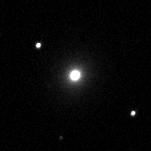

In [4]:
id = ids[27]
@time img_raw = readcsv(joinpath(sampledir, id * "-g.csv"), Float32)
img_gray = colorview(Gray, img_raw)

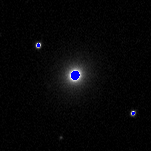

In [5]:
img_peaks = copy(img_raw)
cutoff = min(1, img_raw[fld.(size(img_raw), 2)...])
img_peaks[img_peaks .> 1] = 0
img = colorview(RGB, img_peaks,img_peaks,img_raw)

In [6]:
summary(img)

"151×151 ColorView{RGB}(::ImageCore.StackedView{Float32,3,Tuple{Array{Float32,2},Array{Float32,2},Array{Float32,2}}}) with element type ColorTypes.RGB{Float32}"

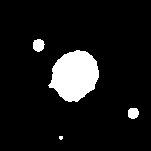

In [7]:
img_bin = falses(img_raw)
img_smooth = imfilter(img_raw, Kernel.gaussian(2))
bin_th = 0.05
img_bin[img_smooth .> bin_th] = true
colorview(Gray, img_bin)

In [8]:
labs = label_components(img_bin);

centre = fld.(size(labs), 2)
labs_blob = zeros(img_raw)
labs_ind = labs .== labs[centre...]
labs_blob[labs_ind] = 0.5

0.5

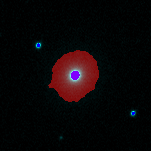

In [9]:
img_labs = colorview(RGB, labs_blob,img_peaks,copy(img_raw))

In [10]:
# find box around center that contains the galaxy based on the center label. 
#It's robust by using the galaxy symmetry so we take minimum of opposite directions
@everywhere function findbox(inds)
    ci, cj = fld.(size(inds), 2)
    north = east = south = west = 0
    for j = 1:size(inds, 2)
        for i = 1:size(inds, 1)
            if inds[i,j]
                if i < ci #north
                    ci - i > north && (north = ci - i)
                else #south
                    i - ci > south && (south = i - ci)
                end
                if j < cj
                    cj - j > west  && (west  = cj - j)
                else
                    j - cj > east  && (east  = j - cj)
                end
            end
        end
    end
    min_width  = min(east, west) 
    min_heigth = min(north, south)
    return min_width, min_heigth
end
findbox(labs_ind)   

(24,24)

In [16]:
@benchmark findbox($labs_ind) #it's fast, thanks Julia!

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     291.487 μs (0.00% GC)
  median time:      321.457 μs (0.00% GC)
  mean time:        339.062 μs (0.00% GC)
  maximum time:     1.559 ms (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [11]:
# draw the box on the image
function drawcbox!(img, w, h) #width, height
    ci, cj = fld.(size(img), 2)
    T = eltype(img)
    # left ,right
    for i = ci-h:ci+h
        img[i, cj-w] = one(T)
        img[i, cj+w] = one(T)
    end
    # up,down
    for j = cj-w:cj+w
        img[ci+h, j] = one(T)
        img[ci-h, j] = one(T)
    end
    img
end

drawcbox! (generic function with 1 method)

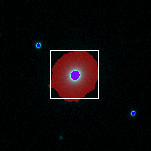

In [12]:
drawcbox!(img_labs, findbox(labs_ind)...)

# interactively look at preprocessing result of sample images

In [18]:
function idplot(i, binth=0.05)
    sampledir = "/Users/ken/Coding/astrohack/Astrohack/Sample_Data/SAMPLE/"
    img_raw = readcsv(joinpath(sampledir, ids[i]*"-g.csv"))#, Float32)
    ci, cj = fld.(size(img_raw), 2)
    
    img_peaks = copy(img_raw)
    cutoff = min(1, img_raw[ci, cj])
    img_peaks[img_peaks .> cutoff] = 0
    
    img_bin = falses(img_raw)
    img_smooth = imfilter(img_raw, Kernel.gaussian(2))
    img_bin[img_smooth .> binth] = true
    labels = label_components(img_bin)
    img_cblob = zeros(img_raw)
    labs_ind = labels .== labels[ci, cj]
    img_cblob[labs_ind] = 0.5
    
    img_labs = colorview(RGB, img_cblob, img_peaks, img_raw)
    
    #img_circles = copy(img_labs)
    blobs = blob_LoG(img_raw, 1:4) #TODO issue for float32?
    blobth = 0.1
    bigblobs = [blob for blob in blobs if blob.amplitude > blobth]
    for blob in bigblobs
        circle = CirclePointRadius(blob.location, sqrt(2)*blob.σ)
        draw!(img_labs, circle, RGB(one(eltype(img_raw)),0,0))
    end
                
    drawcbox!(img_labs, findbox(labs_ind)...)
end

idplot (generic function with 2 methods)

Interact.Options{:SelectionSlider,Int64}(input-7: Signal{Int64}(27, nactions=1),"i",27,"27",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(2=>"2",11=>"11",39=>"39",46=>"46",25=>"25",42=>"42",29=>"29",8=>"8",20=>"20",14=>"14"…)),Any[],Any[],true,"horizontal")

Interact.Options{:SelectionSlider,Float64}(input-8: Signal{Float64}(0.045, nactions=1),"binth",0.045,"0.045",Interact.OptionDict(DataStructures.OrderedDict("0.01"=>0.01,"0.015"=>0.015,"0.02"=>0.02,"0.025"=>0.025,"0.03"=>0.03,"0.035"=>0.035,"0.04"=>0.04,"0.045"=>0.045,"0.05"=>0.05,"0.055"=>0.055…),Dict(0.055=>"0.055",0.015=>"0.015",0.04=>"0.04",0.08=>"0.08",0.045=>"0.045",0.01=>"0.01",0.07=>"0.07",0.06=>"0.06",0.05=>"0.05",0.075=>"0.075"…)),Any[],Any[],true,"horizontal")

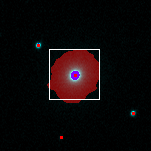

In [20]:
@manipulate for i = 1:length(ids), 
    binth = 0.01:0.005:0.08
        idplot(i, binth)
end

# quick and dirty approach
(= only entropy and symmetrie)
## Preprocess
- smooth image and threshold to create binary image and use `label_components` to find central galaxy. 
- crop central galaxy by using symmetry: minimum of deviations around center for each axis
- set non-label components in crop to zero
## Features
- distances (given)
- lower percentiles for full image for noise level (eg lower 1 and 5 percentile)
- entropy of crop,
- add sum of values and number of galaxy (nonzero) pixels
- some symmetry measures from eigenvalues

Then run good ol' XGBoost on features

## further ideas
- entropy after fitting and removing (two consecutive?) gaussian fits
- use `imROF` for denoising
- cut off peaks higher than center value? 
- remove remaining galaxies/stars in the crop instead of crude non-labels to zero by fitting gaussian

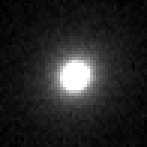

In [184]:
ci, cj = fld.(size(img_raw), 2)
BOXMIN = 10
cwidth, cheight = max(findbox(labs_ind), (BOXMIN,BOXMIN))

img_crop = img_raw[ci-cheight:ci+cheight, cj-cwidth:cj+cwidth]
colorview(Gray, img_crop)

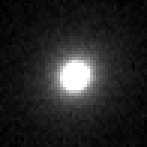

In [32]:
img_onlycblob = copy(img_raw)
img_onlycblob[!labs_ind] = 0
boxsize = max(cwidth, cheight)
img_box = img_raw[ci-boxsize:ci+boxsize, cj-boxsize:cj+boxsize]
colorview(Gray, img_box)

In [37]:
@time reseigs = eigs(img_box, nev=10)
norm.(reseigs[1]).^2

  0.002158 seconds (738 allocations: 61.313 KB)


10-element Array{Float32,1}:
 645.704    
  17.6002   
   0.942475 
   0.887299 
   0.0973208
   0.093082 
   0.0130057
   0.0130057
   0.0113171
   0.0113171

In [36]:
@time reseigs = eigs(img_crop'*img_crop, nev=10)
norm.(reseigs[1])

  0.001327 seconds (286 allocations: 31.688 KB)


10-element Array{Float32,1}:
 647.59     
  17.7356   
   1.0503   
   0.901244 
   0.144213 
   0.129747 
   0.0570758
   0.0509714
   0.0372561
   0.0361984

In [165]:
entropy(img_crop)

4.054558771384226

In [183]:
noise = img_crop - imfilter(img_crop, Kernel.gaussian(1))

maximum(noise)

0.5881191265860775

In [175]:
entropy(img_crop - imfilter(img_crop, Kernel.gaussian(2)))

2.7846815517236028

# Process function

In [5]:
using StatsBase

In [1]:
addprocs();

In [16]:
@everywhere using Images

In [6]:
traindir = "/Users/ken/Coding/astrohack/Train/"
trainlist = readdir(traindir);

In [41]:
# remove i-pics once
# i_files = filter(x->x[end-4]=='i', trainlist)
# cd(traindir)
# for file in i_files
#     rm(file)
# end

In [49]:
using DataFrames

In [196]:
trainmeta = readtable("/Users/ken/Coding/astrohack/Train.csv",separator=';')
sort!(trainmeta) #sort on ID to match directory listing!

,SDSS_ID,logMstar,err_logMstar,Distance
1,1237645879578460255,11.100999999999999,0.028999999999999998,518.0174523561253
2,1237645941824356443,10.539000000000001,0.032,172.10307774074076
3,1237645943974396134,11.318,0.015,654.2479282849002
4,1237645943975837722,10.862,0.026000000000000002,285.27259536182333
5,1237645943978328289,9.485,0.042,165.69725598860398
6,1237645943978393694,10.755999999999998,0.028999999999999998,173.81129687464386
7,1237645943978983579,10.168,0.024,207.54862476923074
8,1237645943978983683,11.792,0.017,794.3218972649573
9,1237645943979114622,10.932,0.044000000000000004,168.25958468945865
10,1237645943979507954,10.82,0.012,158.43732466951565


In [51]:
size(trainmeta,1) == length(trainlist)

true

In [191]:
@everywhere function process(file)
    
    BINTH  = 0.05 # chosen by eye
    BOXMIN = 10   # minimum crop of 100 pixels
    T = Float32   # typical premature optimization
    
    img_raw = readcsv(file, T) 
    ci, cj = fld.(size(img_raw), 2)
    
    # get percentiles for noise levels
    img_vec = reshape(img_raw, length(img_raw))
    p1 = StatsBase.percentile(img_vec, 1)
    p2 = StatsBase.percentile(img_vec, 5)
    
    # select the galaxy by thresholding smoothed image and labeling blobs
    img_smooth = imfilter(T, img_raw, Kernel.gaussian(2))
    img_bin = img_smooth .> BINTH
    labels = label_components(img_bin)
    labs_ind = labels .== labels[ci, cj]
    
    # crop galaxy
    cwidth, cheight = max(findbox(labs_ind), (BOXMIN,BOXMIN))
    crop_ind = ci-cheight:ci+cheight, cj-cwidth:cj+cwidth
    img_crop = img_raw[crop_ind...]

    #Crudely set non galaxy values in crop to zero to remove possible other galaxy
    labels_ind_crop = labs_ind[crop_ind...]
    img_crop[!labels_ind_crop] = 0
    
    # get top eigenvalues (spectra) for symmetry features
    reseigs = eigs(img_crop'*img_crop, nev=10)
    spect = norm.(reseigs[1])
    
    # get sum of intensities and (squared) noise
    s1 = sum(img_crop)
    img_crop_smooth = view(img_smooth, crop_ind...)
    s2 = sum(img_crop - img_crop_smooth)
    s3 = sum((img_crop - img_crop_smooth).^2)
    s4 = sum(labs_ind) #number of galaxy pixels 
    s5 = norm(img_crop) #why not..
    
    # get entropy 
    e1 = Images.entropy(img_crop)
    e2 = Images.entropy(img_crop - imfilter(T, img_crop, Kernel.gaussian(2)))
    
    return T[p1,p2, s1, s2, s3, s4, s5, e1, e2, spect...]
end

(Any) in module Main at In[189]:3 overwritten at In[191]:3.


In [193]:
# test the function
@time process(joinpath(traindir, trainlist[10]))

  0.011020 seconds (35.67 k allocations: 2.102 MB)


19-element Array{Float32,1}:
   -0.019007 
   -0.0117548
  309.332    
  -11.8464   
   39.1035   
 1283.0      
   19.6011   
    4.088    
    3.27034  
  384.204    
    8.92826  
    0.288739 
    0.174709 
    0.0511862
    0.0380456
    0.0332355
    0.0284405
    0.0271679
    0.0230588

In [217]:
# test on other worker thread
@time remotecall_fetch(process, 2, joinpath(traindir, trainlist[10]))

  0.009558 seconds (162 allocations: 8.563 KB)


19-element Array{Float32,1}:
   -0.019007 
   -0.0117548
  309.332    
  -11.8464   
   39.1035   
 1283.0      
   19.6011   
    4.088    
    3.27034  
  384.204    
    8.92826  
    0.288739 
    0.174709 
    0.0511882
    0.0380461
    0.0332357
    0.0284385
    0.0271685
    0.0230591

In [68]:
# @time begin
#     N = 100
#     fs = zeros(N, 15)
#     fs[:, 1] = trainmeta[:Distance][1:N]
#     @sync @parallel for i=1:N
#         file = joinpath(traindir, trainlist[i])
#         fs[i, 2:end] = process(file)
#     end
# end

In [197]:
# process all train images in parallel and extract features
# longest step, about 6 minutes on my 2015 macbook pro
@time resmap = pmap(process, String[joinpath(traindir, f) for f in trainlist]);

387.255984 seconds (11.21 M allocations: 448.294 MB, 0.18% gc time)


In [278]:
feats = zeros(eltype(resmap[1]), length(resmap), 1+length(resmap[1]))
feats[:, 1] = trainmeta[:Distance]
for i = 1:length(resmap)
    feats[i, 2:end] = resmap[i]
end

In [201]:
values = convert(Array{Float32}, trainmeta[:logMstar]);

# Regression
XGBoost has a known [compile issue](https://xgboost.readthedocs.io/en/latest/build.html#building-on-osx) on mac because clang does not come with multithreaded OpenMP installed.
So I installed gcc with homebrew `brew install gcc --without-multilib`, but you still have to link gcc-6 and g++-6 locally! 
I installed `Pkg.add("XGBoost")` and in the `deps` folder I copied the config.mk to main xgboost folder and changed the gcc and g++ to local /usr/local/bin/gcc-6 paths.

In [218]:
using XGBoost 

In [219]:
sum(values .== -99) #missing values!

1374

In [204]:
# with removing missing values (god damnit)
nrows = length(resmap) - sum(values.==-99)
T = eltype(resmap[1])
feats2 = zeros(T, nrows, size(feats, 2))
values2 = zeros(T, nrows)
err2 = zeros(T, nrows)
currenti = 1
for i = 1:length(resmap)
    if values[i] != -99
        feats2[currenti, 1] = trainmeta[:Distance][i]
        feats2[currenti, 2:end] = resmap[i]
        values2[currenti] = values[i]
        err2[currenti] = trainmeta[:err_logMstar][i]
        currenti += 1
    end
end
size(feats2)

(74891,20)

In [205]:
using Plots
gr()

Plots.GRBackend()

In [206]:
histogram(values2)

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 8 
 
 
 9 
 
 
 10 
 
 
 11 
 
 
 12 
 
 
 0 
 
 
 2500 
 
 
 5000 
 
 
 7500 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 y1

In [208]:
rand_ids = shuffle(1:length(values2));

train_n = length(values2) - 1734
train_ids = rand_ids[1:train_n]

#train_sample = sample(1:length(feats), train_n, replace=false)
train_x = feats2[train_ids, :]
train_y = values2[train_ids]

test_n  = 1734
test_ids= rand_ids[train_n:train_n+test_n]
test_x  = feats2[test_ids, :]
test_y  = values2[test_ids]
test_err= err2[test_ids];

In [209]:
@time boost = xgboost(train_x, 50, label=train_y, max_depth=50, learning_rate=0.3)

[1]	train-rmse:7.053658
[2]	train-rmse:4.942040
[3]	train-rmse:3.464624
[4]	train-rmse:2.431568
[5]	train-rmse:1.710097
[6]	train-rmse:1.207397
[7]	train-rmse:0.858015
[8]	train-rmse:0.615704
[9]	train-rmse:0.447069
[10]	train-rmse:0.328264
[11]	train-rmse:0.243532
[12]	train-rmse:0.182273
[13]	train-rmse:0.137520
[14]	train-rmse:0.104366
[15]	train-rmse:0.079667
[16]	train-rmse:0.061113
[17]	train-rmse:0.047157
[18]	train-rmse:0.036617
[19]	train-rmse:0.028589
[20]	train-rmse:0.022415
[21]	train-rmse:0.017671
[22]	train-rmse:0.014006
[23]	train-rmse:0.011178
[24]	train-rmse:0.008958
[25]	train-rmse:0.007220
[26]	train-rmse:0.005842
[27]	train-rmse:0.004757
[28]	train-rmse:0.003882
[29]	train-rmse:0.003181
[30]	train-rmse:0.002616
[31]	train-rmse:0.002161
[32]	train-rmse:0.001797
[33]	train-rmse:0.001501
[34]	train-rmse:0.001260
[35]	train-rmse:0.001060
[36]	train-rmse:0.000909
[37]	train-rmse:0.000785
[38]	train-rmse:0.000686
[39]	train-rmse:0.000604
[40]	train-rmse:0.000551
[41]	trai

 15.151809 seconds (7.82 k allocations: 6.371 MB)


[45]	train-rmse:0.000464
[46]	train-rmse:0.000464
[47]	train-rmse:0.000464
[48]	train-rmse:0.000464
[49]	train-rmse:0.000464
[50]	train-rmse:0.000464


XGBoost.Booster(Ptr{Void} @0x00007f9bcb14c100)

In [210]:
test_pred = XGBoost.predict(boost, test_x);

In [211]:
hcat(test_y, test_pred, test_err)

1735×3 Array{Float32,2}:
 11.182  11.182    0.009
 11.51   11.5777   0.026
 10.907  10.8396   0.037
 10.59   10.5571   0.041
 11.42   11.2049   0.031
 10.256  10.011    0.024
 11.171  10.6016   0.025
  9.349   9.34016  0.055
 10.296  10.2444   0.014
 10.941  10.942    0.01 
 10.71   10.7143   0.042
 11.307  11.2312   0.034
  9.463   9.29443  0.045
  ⋮                     
  9.971  10.0718   0.03 
 10.808  10.8301   0.022
 10.317  10.4416   0.056
  9.23    9.22179  0.056
  9.746   9.84914  0.033
 11.514  11.4574   0.029
 10.371  10.3303   0.021
 10.349  10.3235   0.033
 10.192   9.96918  0.063
 10.101  10.2186   0.028
 10.792  11.0878   0.023
 10.557  10.4991   0.034

In [212]:
sum((test_y - test_pred).^2 ./ (test_err.^2))

133952.8f0

# Submission

In [236]:
sub_ids = readcsv("validationdata_SDSSID.csv", Int, header=false)
# sort!
sub_ids = sort!(reshape(sub_ids, length(sub_ids))) 
sub_dir = "/Users/ken/Coding/astrohack/Test/"
sub_files = [joinpath(sub_dir, string(id) * "-g.csv") for id in sub_ids];

In [273]:
length(sub_ids)

1734

BoundsError: BoundsError: attempt to access 13-element Array{UInt8,1} at index [-1]

In [251]:
testfiles = readdir(sub_dir);

In [248]:
# remove i-pics once
# i_files = filter(x->x[end-4]=='i', testfiles)

# cd(sub_dir)
# for file in i_files
#     rm(file)
# end

In [254]:
@time subresmap = pmap(process, sub_files);

  7.182995 seconds (234.93 k allocations: 9.468 MB)


In [291]:
submeta = readtable("/Users/ken/Coding/astrohack/Test_Distance.csv",separator=';')
sort!(submeta)

,SDSS_ID,Distance
1,1237645943978590386,160.57259858689457
2,1237645943979114582,169.9678038233618
3,1237645943979311221,152.88561248433047
4,1237648672922468973,198.58047431623933
5,1237648673992671592,232.3178022108262
6,1237648674529476993,137.08458549572646
7,1237648674532753564,371.5376616239317
8,1237648675603874096,140.07396898005695
9,1237648702972887077,367.6941685726495
10,1237648702978654353,212.67328217094013


In [261]:
size(submeta)

(8447,2)

In [271]:
sub_ids_df = DataFrame(SDSS_ID=sub_ids)
submeta2 = join(submeta, sub_ids_df, on=:SDSS_ID, kind=:inner)

,SDSS_ID,Distance
1,1237645943979114582,169.9678038233618
2,1237648672922468973,198.58047431623933
3,1237648702986125622,518.0174523561253
4,1237648703505432738,102.49314803418802
5,1237648703508119586,98.64965498290596
6,1237648703509758235,366.41300422222224
7,1237648703516508315,510.33046625356116
8,1237648704045908141,132.38698287749284
9,1237648704046563336,54.66301228490028
10,1237648704057966842,357.01779898575495


In [281]:
issorted(submeta2[:SDSS_ID])

true

In [272]:
size(submeta2)

(1734,2)

In [275]:
all(submeta2[:SDSS_ID] .== sub_ids)

true

In [277]:
subfeats = zeros(eltype(subresmap[1]), length(subresmap), 1+length(subresmap[1]))
subfeats[:, 1] = submeta2[:Distance]
for i = 1:length(subresmap)
    subfeats[i, 2:end] = subresmap[i]
end

In [282]:
subpred = XGBoost.predict(boost, subfeats)
submission = DataFrame(pssid=sub_ids,mass=subpred)

,pssid,mass
1,1237645943979114582,10.253867
2,1237648672922468973,10.499608
3,1237648702986125622,11.209326
4,1237648703505432738,9.918384
5,1237648703508119586,9.894254
6,1237648703509758235,10.147396
7,1237648703516508315,11.507912
8,1237648704045908141,10.090234
9,1237648704046563336,10.331856
10,1237648704057966842,11.38165


In [283]:
pwd()

"/Users/ken/Coding/astrohack/Test"

In [285]:
writetable("/Users/ken/Coding/astrohack/AstroWhack_20170510_0515", submission, separator=',') 

# Final submission on full test set

In [ ]:
finalfiles = [joinpath(sub_dir, testfile) for testfile in testfiles];

In [302]:
# i=8447
# @show string(submeta[:SDSS_ID][i])
# string(submeta[:SDSS_ID][i]) == testfiles[i][1:end-6]

string((submeta[:SDSS_ID])[i]) = "1237680241434689718"


true

In [290]:
@time finalresmap = pmap(process, finalfiles)

 36.799306 seconds (1.17 M allocations: 46.200 MB, 0.09% gc time)


8447-element Array{Any,1}:
 Float32[-0.0238069,-0.0166045,122.753,-13.807,0.89608,1065.0,3.29731,3.62816,4.40761,10.8722,4.31777,2.26844,0.833554,0.275684,0.15025,0.0581227,0.0410931,0.0295711,0.0201667]            
 Float32[-0.0221257,-0.0153729,199.564,0.0247038,50.3156,716.0,19.3968,5.25251,3.91166,376.235,3.7299,2.92906,0.109497,0.0354269,0.0155805,0.0129812,0.00972552,0.00561858,0.00497146]      
 Float32[-0.0259305,-0.0183745,294.038,-36.3482,11.5167,2599.0,10.7808,3.27875,3.46207,116.226,6.797,2.36486,1.15873,0.472192,0.194996,0.15448,0.128698,0.0785831,0.0507989]                
 Float32[-0.0401618,-0.0276491,280.714,-8.86661,3.84388,1667.0,8.22684,4.83535,4.30855,67.6808,3.78111,2.04784,0.389971,0.262359,0.177349,0.0999863,0.0742735,0.0623478,0.0538916]          
 Float32[-0.0288486,-0.0188661,347.739,-16.9966,9.24423,1760.0,15.1196,4.04307,4.04472,228.603,5.73363,0.528576,0.162444,0.0975928,0.0851719,0.0542921,0.0489128,0.0413476,0.0390132]       
 Float32[-0.03132,-0.0207546

In [306]:
res = finalresmap
finalfeats = zeros(eltype(res[1]), length(res), 1+length(res[1]))
finalfeats[:, 1] = submeta[:Distance]
for i = 1:length(res)
    finalfeats[i, 2:end] = res[i]
end

In [309]:
finalpred = XGBoost.predict(boost, finalfeats)
finaldf   = DataFrame(pssid=submeta[:SDSS_ID],mass=finalpred)

,pssid,mass
1,1237645943978590386,10.0421915
2,1237645943979114582,10.253867
3,1237645943979311221,10.291842
4,1237648672922468973,10.499608
5,1237648673992671592,11.1321535
6,1237648674529476993,10.320119
7,1237648674532753564,11.115282
8,1237648675603874096,10.217378
9,1237648702972887077,10.962672
10,1237648702978654353,10.688571


In [310]:
writetable("/Users/ken/Coding/astrohack/AstroWhack_final_predictions_20170501", finaldf, separator=',') 